# References
1. [Customer Segmentation](https://www.kaggle.com/fabiendaniel/customer-segmentation)
2. [Customer Segmentation](https://www.kaggle.com/miljan/customer-segmentation)

# 각 커널의 아이디어
# 1. Customer Segmentation
## 1.1 목표
- 고객 세분화
- 신규 고객이 군집에 속할지 예측하는 분류기 만들기

## 1.2 작업 순서
1. 사이트에서 판매하는 다양한 상품을 분석. 5가지 카테고리로 분류
2. 10개월 동안 고객의 소비 습관을 분석하여 고객을 분류 ( 고객이 주로 구매하는 상품의 카테고리, 방문 횟수, 10개월 동안 소비한 금액 등 11가지 기준으로 분류 )
3. 고객이 11개 중 어디에 포함되는지 예측하는 모델 개발
4. 2개월치 데이터로 테스트

## 1.3 전처리
1. `CustomerID`가 null인 트랜잭션 제거
2. 중복되는 트랜잭션 제거
3. `Quantity` <= 0 or `Description` != 'Discount'인 트랜잭션 ( 취소 트랜잭션 )
    - 대응하는 주문이 없으면 삭제
    - 대응하는 주문이 있으면 취소 트랜잭션의 `Quantity`를 `QuantityCanceled`에 추가하고 취소 트랜잭션은 삭제
    - 대응하는 주문이 2개 이상 있으면 마지막 취소 트랜잭션의 `Quantity`를 `QuantityCanceled`에 추가하고 취소 트랜잭션은 삭제

## 1.4 상품 분류
- 상품 Description으로부터 이름 추출
    - nltk.pos_tag 를 통해 명사만을 추출
    - SnowballStemmer로 접사(affix) 제거
    - stemming된 명사를 root로 보며, 같은 root를 가지는 것들을 set에 추가 ( 'root': {'roota', 'rootb', 'rootc'} )
    - 각 root에 해당하는 명사가 여러개인 경우, 길이가 가장 짧은 것을 선택
    - 색상 (pink, blue, ...), 특수기호 ( +, / )가 포함되거나, 이름이 3글자 미만이거나, 이름이 포함되는 상품 수가 13개 미만인 것은 삭제
- 상품 x 상품명 데이터프레임을 만든다
    - 예를 들어, 0번 상품이 'flower', 'decoration'이고, 1번 상품이 'bag'이면 데이터프레임은 다음과 같다.
    |   | flower | decoration | bag |
    |---|--------|------------|-----|
    | 0 | 1      | 1          | 0   |
    | 1 | 0      | 0          | 1   |
- 데이터프레임에 상품의 가격 범주를 원핫인코딩하여 추가
- kmodes 라이브러리의 KModes는 Hamming's metric을 사용하여 군집화
    - 하지만 kmodes는 kaggle에서 사용 불가
    - 어쩔수 없이 KMeans, Euclidean distance를 사용해 군집화 ( 카테고리 변수를 군집화하는데 좋지 않다 )
- Silhouette score가 가장 높은 것은 군집이 8개일 때였지만, 특정 군집에 속하는 상품의 수가 너무 적었다. 그래서 군집의 수를 5로 결정

## 1.5 고객 분류
- `CustomerID`, `InvoiceNo`로 그루핑해 다음을 집계
    - `Basket Price`: 해당 `InvoiceNo`에 포함된 상품의 금액 합계
    - `categ_0`, ..., `categ_4`: 군집 0, 1, 2, 3, 4에 해당하는 금액
    - `InvoiceDate`: `InvoiceDate`의 평균
- `InvoiceDate`가 2011-10-01 미만인 것은 training set, 나머지는 test set으로 활용
- traing set을 `CustomerID`로 그루핑해 다음을 집계
    - `count`, `min`, `max`, `mean`, `sum`: `Basket Price`의 수, 최소값, 최대값, 평균, 합
    - `categ_0`, ..., `categ_4`: 군집 0, 1, 2, 3, 4에 해당하는 금액
    - `FirstPurchase`, `LastPurchase`: 첫 구매, 마지막 구매로부터 지난 날짜
- training set을 Standard Scaling
- training set를 K-Means 클러스터링
    - Silhouette score를 적용하여 군집의 수를 결정
    - 군집 수는 11개이며, silhouette score는 0.216
    - 여기에서 만든 군집을 지도학습의 라벨로 사용
- 클러스터링이 잘 되었는지 확인하는 방법은 다음과 같다.
    1. Report via the PCA: PCA components를 두개씩 짝지어서 시각화하여 군집들을 잘 구분하는지 확인
    2. Silhouette score
    3. Customers morphotype: 군집별 통계치를 비교하여 군집이 잘 되었는지 확인
    4. Customers morphology: Radar Charts를 그려서 비교 ( 3과 비슷함 )

## 1.6 고객 분류기 만들기
- 첫 번째 방문과 동시에 바구니 내용을 설명하는 변수만 유지하고, 시간에 따른 바구니 가격 변동이나 방문 빈도와 관련된 변수는 제외
- 사용한 분류기는 다음과 같다.
    1. SVC
    2. Logistic Regression
    3. K-Nearest Neighbors
    4. Decision Tree
    5. Random Forest
    6. AdaBoost Classifier
    7. Gradient Boosting Classifier
- Random Forest, Gradient Boosting Classifier, K-Nearest Neighbors을 soft voting하였음 ( 3개의 분류기는 테스트셋에서 가장 좋은 성능을 내는 것으로 선택됨 )
- training precision은 91.27%
- test precision은 76.48

# 2. Customer Segmentation
## 2.1 전처리
- drop if `CustomerID` is null
- `Quantity` <= 0 or `Description` != 'Discount'인 트랜잭션 ( 취소 트랜잭션 )
    - 1번 커널과 동일
- drop if `Quantity` < 0 & `StockCode` != 'D'
- 문자열로만 이루어진 `StockCode` 삭제 ( ex. 'POST', 'D' )
- Label Encoding `Country`

## 2.2 Customer Segementation
### 2.2.1 TotalPrice
- `TotalPrice` = `UnitPrice` * (`Quantity` - `QuantityCanceled`)

### 2.2.2 [RFM Analysis](https://www.kaggle.com/blanik/kor-e-commerce-data-2-rfm-analysis)
- 4개 등급으로 나눔
- 점수를 문자열로 간주하고 합침
- '111'이 가장 좋은 고객

### 2.2.3 Time Features
- `Month`, `Weekday`, `Day`, `Hour`

### 2.2.4 Product Categories
- TfidfVectorizer 사용해 `Descripotion`을 벡터화 ( shape: (3871,1694) )
    - stem_and_filter라는 함수 정의하여 analyzer로 사용 ( PorterStemmer로 접사 제거 )
- TruncatedSVD로 TfidfVector 100차원으로 축소 ( shape: (3871,100) )
- K-Means 적용하여 군집화
    - Silhouette Score 비교하여 군집 성능 측정
    - 군집의 수를 135개로 결정

### 2.2.5 Customer Categories
- `min`, `max`, `mean`, `min_recency`, `max_recency`, `frequency`, `monetary_value`, `quantity`, `country`
    - (4335, 9)
- 고객이 상품 군집별로 얼마나 썼는지 비율로 표현
    - 위에서 상품 군집을 135개로 결정했으므로, 행렬은 (4335, 135) 이다.
- 위에 있는 두 데이터프레임을 concat하여 (4335, 144) 행렬 만듦.
- K-means clustering을 통해 군집화
    - Silhouette score를 비교해 8개의 군집으로 만들기로 결정

## 2.3 Interpreting the clusters
### 2.3.1 TSNE
- 2차원으로 차원축소를 시켜 시각화
- 군집들이 서로 구분되는지 것을 확인

### 2.3.2 통계치 비교
- Cluster 2: high frequency with a lot of quantity (mean basket price of 513) bought on average and high monetary value (VIP clients)
- Cluster 7 : very high purchase frequency with a mean basket price of 150 but good monetary value.
- Cluster 4: very high basket price (huge quantity of products bought on average)
- Cluster 0: good average customers
- Cluster 6: good foreign customers
- Cluster 1: almost lost customers
- Cluster 5: highest monetary value but only one or two purchases over the year
- Cluster 3: lost customers

# 참고자료 요약
1. 전에 다뤘던 [RFM Analysis](https://www.kaggle.com/blanik/kor-e-commerce-data-2-rfm-analysis)는 Customer Segementation의 방법 중 하나로 보이며, 커널 2의 경우 실제로 segmentation을 할 때 RFM Analysis의 결과를 사용하기도 했다. RFM Analysis는 Recency, Frequency, Monetary만을 쓰는 반면, 여기서는 훨씬 다양한 정보를 사용해 고객을 분류한다.
2. 두 커널 모두 상품을 군집화해 해당 군집에 해당하는 상품들에 돈을 얼마나 썼는지를 변수로 사용한다. 상품을 군집화하기 위해서는 텍스트 데이터를 벡터로 만들어야 하는데, 아이디어가 달랐다.
    1. 커널 1: 상품명에 해당하는 것을 찾으려고 노력. 이후 원핫인코딩
    2. 커널 2: TfidfVectorizer로 벡터화, TruncatedSVD로 차원 축소.
3. 1번 커널의 상품 벡터는 sparse vector가 되었으며, 2번 커널의 상품 벡터는 dense vector가 되었다.
    - 둘 다 K-Means를 사용하였으나, 1번 커널의 저자에 따르면 K-Means는 sparse vecotr(카테고리)를 군집화하는 데 좋지 않다고 한다.
    - K-Means 대신 K-Modes를 사용하길 제안
4. 고객 군집에 사용되는 features는 다음과 같다.
    - Basket Price의 수, 최소값, 최대값, 평균, 합
    - 상품 군집에 해당하는 금액
    - 첫 구매, 마지막 구매로부터 지난 날짜
    - min_recency, max_recency, frequency, monetary_value, quantity, country
5. 1번 커널은 고객 군집화를 마친 후에 성능 평가를 다양한 방법으로 했다.
6. 1번 커널은 고객이 어떤 군집에 속하는지 예측하는 분류기를 따로 만들었는데, 왜 만들었는지 모르겠다.

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, nltk, warnings
import matplotlib.cm as cm
import itertools
from pathlib import Path
from kmodes.kmodes import KModes
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
from wordcloud import WordCloud, STOPWORDS
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from IPython.display import display, HTML
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
%matplotlib inline

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ecommerce-data/data.csv


# 1. 데이터 로드

In [3]:
df = pd.read_csv('/kaggle/input/ecommerce-data/data.csv', 
                 dtype={'InvoiceNo': str, 'StockCode': str, 'Description': str, 'Quantity': int, 'UnitPrice': float, 'CustomerID': str, 'Country': str}, 
                 encoding='ISO-8859-1',
                 parse_dates=['InvoiceDate'])
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  object        
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 33.1+ MB


In [5]:
df.describe()

,Quantity,UnitPrice
count,541909.000000,541909.000000
mean,9.552250,4.611114
std,218.081158,96.759853
min,-80995.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,38970.000000


In [6]:
df.nunique().to_frame().transpose()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,25900,4070,4223,722,23260,1630,4372,38


# 2. 간단한 데이터 전처리

In [7]:
df = df[
    (df['Country'] == 'United Kingdom') &
    (~df['CustomerID'].isnull()) &
    (~df['InvoiceNo'].str.startswith('C')) &
    (df['Quantity'] > 0) & 
    (df['UnitPrice'] > 0) & 
    (~df['StockCode'].str.isalpha()) &
    (~df['StockCode'].str.contains('BANK|C2|DCGS|gift'))
].reset_index(drop=True)
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [8]:
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


# 3. 상품 군집화

In [9]:
is_noun = lambda pos: pos[:2] == 'NN'

def keywords_inventory(dataframe, col='Description'):
    stemmer = nltk.stem.SnowballStemmer("english")
    keywords_roots  = dict()  # collect the words / root
    keywords_select = dict()  # association: root <-> keyword
    category_keys   = []
    count_keywords  = dict()
    icount = 0
    for s in dataframe[col]:
        if pd.isnull(s): continue
        lines = s.lower()
        tokenized = nltk.word_tokenize(lines)
        nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)] 
        
        for t in nouns:
            t = t.lower()
            racine = stemmer.stem(t)
            if racine in keywords_roots:
                keywords_roots[racine].add(t)
                count_keywords[racine] += 1                
            else:
                keywords_roots[racine] = {t}
                count_keywords[racine] = 1
    
    for s in keywords_roots.keys():
        if len(keywords_roots[s]) > 1:  
            min_length = 1000
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    clef = k ; min_length = len(k)            
            category_keys.append(clef)
            keywords_select[s] = clef
        else:
            category_keys.append(list(keywords_roots[s])[0])
            keywords_select[s] = list(keywords_roots[s])[0]
            
    print("Nb of keywords in variable '{}': {}".format(col,len(category_keys)))
    return category_keys, keywords_roots, keywords_select, count_keywords

In [10]:
df_products = pd.DataFrame(df['Description'].unique()).rename(columns = {0:'Description'})
df_products.head()

,Description
0,WHITE HANGING HEART T-LIGHT HOLDER
1,WHITE METAL LANTERN
2,CREAM CUPID HEARTS COAT HANGER
3,KNITTED UNION FLAG HOT WATER BOTTLE
4,RED WOOLLY HOTTIE WHITE HEART.


In [11]:
keywords, keywords_roots, keywords_select, count_keywords = keywords_inventory(df_products)

Nb of keywords in variable 'Description': 1473


In [12]:
list_products = []
for k,v in count_keywords.items():
    word = keywords_select[k]
    if word in ['pink', 'blue', 'tag', 'green', 'orange']: continue
    if len(word) < 3 or v < 13: continue
    if ('+' in word) or ('/' in word): continue
    list_products.append([word, v])

list_products.sort(key = lambda x:x[1], reverse = True)
print(list_products[:5])
print('mots conservés:', len(list_products))

[['heart', 265], ['vintage', 210], ['set', 206], ['bag', 161], ['box', 153]]
mots conservés: 190


In [13]:
liste_produits = df['Description'].unique()
X = pd.DataFrame()
for key, occurence in list_products:
    X.loc[:, key] = list(map(lambda x:int(key.upper() in x), liste_produits))
X

,heart,vintage,set,bag,box,glass,christmas,design,candle,holder,...,toadstool,tidy,plant,house,square,diner,lace,pan,wallet,point
0,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3833,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3834,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3835,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3836,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
threshold = [0, 1, 2, 3, 5, 10]
label_col = []
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])
    label_col.append(col)
    X.loc[:, col] = 0

for i, prod in enumerate(liste_produits):
    prix = df[ df['Description'] == prod]['UnitPrice'].mean()
    j = 0
    while prix > threshold[j]:
        j+=1
        if j == len(threshold): break
    X.loc[i, label_col[j-1]] = 1
X

,heart,vintage,set,bag,box,glass,christmas,design,candle,holder,...,lace,pan,wallet,point,0<.<1,1<.<2,2<.<3,3<.<5,5<.<10,.>10
0,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3833,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3834,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3835,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
3836,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0


In [15]:
print("{:<8} {:<20} \n".format('gamme', 'nb. produits') + 20*'-')
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])    
    print("{:<10}  {:<20}".format(col, X.loc[:, col].sum()))

gamme    nb. produits         
--------------------
0<.<1       968                 
1<.<2       997                 
2<.<3       653                 
3<.<5       604                 
5<.<10      466                 
.>10        150                 


실험결과는 아래와 같으며, 예상과 다르게 K-Means의 성능이 가장 좋았다.

In [16]:
# for n_clusters in range(3,10):
#     kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30, random_state=42)
#     kmeans.fit(X)
#     clusters = kmeans.predict(X)
# #     kmodes = KModes(n_clusters=n_clusters, init='Cao', n_init=5, verbose=0, random_state=42)
# #     clusters = kmodes.fit_predict(X)
#     silhouette_avg = silhouette_score(X, clusters)
#     print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

#     # K-Means
#     # For n_clusters = 3 The average silhouette_score is : 0.102948308223902
#     # For n_clusters = 4 The average silhouette_score is : 0.12811789850480998
#     # For n_clusters = 5 The average silhouette_score is : 0.12699637806397684
#     # For n_clusters = 6 The average silhouette_score is : 0.1574539201632419
#     # For n_clusters = 7 The average silhouette_score is : 0.14819126448170802
#     # For n_clusters = 8 The average silhouette_score is : 0.15185568045328124
#     # For n_clusters = 9 The average silhouette_score is : 0.14261087252384386

#     # K-Modes ( Huang )
#     # For n_clusters = 3 The average silhouette_score is : 0.07598815097161264
#     # For n_clusters = 4 The average silhouette_score is : 0.1056654702332311
#     # For n_clusters = 5 The average silhouette_score is : 0.14918484477746594
#     # For n_clusters = 6 The average silhouette_score is : 0.07704652533161353
#     # For n_clusters = 7 The average silhouette_score is : 0.13678160470342732
#     # For n_clusters = 8 The average silhouette_score is : 0.10737535417531055
#     # For n_clusters = 9 The average silhouette_score is : 0.06458357446364324

#     # K-Modes ( Cao )
# #     For n_clusters = 3 The average silhouette_score is : 0.11613277588446597
# #     For n_clusters = 4 The average silhouette_score is : 0.10393865789571573
# #     For n_clusters = 5 The average silhouette_score is : 0.101405159342249
# #     For n_clusters = 6 The average silhouette_score is : 0.09791048809026176
# #     For n_clusters = 7 The average silhouette_score is : 0.09936970523007022
# #     For n_clusters = 8 The average silhouette_score is : 0.0989687901831909
# #     For n_clusters = 9 The average silhouette_score is : 0.0942020466189543

In [17]:
n_clusters = 6
kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
kmeans.fit(X)
clusters = kmeans.predict(X)
silhouette_avg = silhouette_score(X, clusters)
print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 6 The average silhouette_score is : 0.1472202452174209


In [18]:
pd.Series(clusters).value_counts()

3    906
2    895
4    608
0    575
5    557
1    297
dtype: int64

In [19]:
def graph_component_silhouette(n_clusters, lim_x, mat_size, sample_silhouette_values, clusters):
    plt.rcParams["patch.force_edgecolor"] = True
    plt.style.use('fivethirtyeight')
    mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
    #____________________________
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(8, 8)
    ax1.set_xlim([lim_x[0], lim_x[1]])
    ax1.set_ylim([0, mat_size + (n_clusters + 1) * 10])
    y_lower = 10
    for i in range(n_clusters):
        #___________________________________________________________________________________
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[clusters == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = cm.get_cmap("Spectral")
        color = cmap(float(i) / n_clusters)        
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                           facecolor=color, edgecolor=color, alpha=0.8)
        #____________________________________________________________________
        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.03, y_lower + 0.5 * size_cluster_i, str(i), color = 'red', fontweight = 'bold',
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round, pad=0.3'))
        #______________________________________
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10

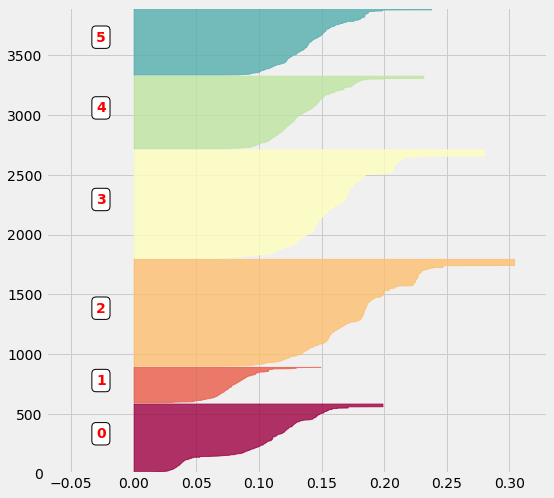

In [20]:
#____________________________________
# define individual silouhette scores
sample_silhouette_values = silhouette_samples(X, clusters)
#__________________
# and do the graph
graph_component_silhouette(n_clusters, [-0.07, 0.33], len(X), sample_silhouette_values, clusters)

In [21]:
corresp = dict()
for key, val in zip (liste_produits, clusters):
    corresp[key] = val 
    
df['categ_product'] = df.loc[:, 'Description'].map(corresp)
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,categ_product
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,5
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,5
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,1


# 4. 고객 군집화

In [22]:
for i in range(6):
    col = 'categ_{}'.format(i)
    df_temp = df[df['categ_product'] == i]
    price_temp = df_temp['UnitPrice'] * df_temp['Quantity']
    price_temp = price_temp.apply(lambda x:x if x > 0 else 0)
    df.loc[:, col] = price_temp
    df[col].fillna(0, inplace = True)

df[['InvoiceNo', 'Description', 'categ_product', 'categ_0', 'categ_1', 'categ_2', 'categ_3','categ_4', 'categ_5']][:5]

,InvoiceNo,Description,categ_product,categ_0,categ_1,categ_2,categ_3,categ_4,categ_5
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,1,0.0,15.30,0.0,0.0,0.0,0.00
1,536365,WHITE METAL LANTERN,5,0.0,0.00,0.0,0.0,0.0,20.34
2,536365,CREAM CUPID HEARTS COAT HANGER,1,0.0,22.00,0.0,0.0,0.0,0.00
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,5,0.0,0.00,0.0,0.0,0.0,20.34
4,536365,RED WOOLLY HOTTIE WHITE HEART.,1,0.0,20.34,0.0,0.0,0.0,0.00


In [23]:
temp = df.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
basket_price = temp.rename(columns = {'TotalPrice':'Basket Price'})
basket_price.head()

,CustomerID,InvoiceNo,Basket Price
0,12346,541431,77183.60
1,12747,537215,358.56
2,12747,538537,347.71
3,12747,541677,303.04
4,12747,545321,310.78


In [24]:
for i in range(6):
    col = 'categ_{}'.format(i)
    temp = df.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)[col].sum()
    basket_price = pd.merge(basket_price, temp, how='left', on=['CustomerID', 'InvoiceNo'])
basket_price.head()

,CustomerID,InvoiceNo,Basket Price,categ_0,categ_1,categ_2,categ_3,categ_4,categ_5
0,12346,541431,77183.60,0.00,0.0,0.0,77183.60,0.0,0.0
1,12747,537215,358.56,199.80,32.7,0.0,80.16,45.9,0.0
2,12747,538537,347.71,100.35,95.2,0.0,60.36,91.8,0.0
3,12747,541677,303.04,199.80,0.0,10.2,27.04,66.0,0.0
4,12747,545321,310.78,39.80,15.9,10.2,73.88,156.0,15.0


In [25]:
df['InvoiceDate_int'] = df['InvoiceDate'].astype('int64')
temp = df.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
df.drop('InvoiceDate_int', axis = 1, inplace = True)
basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])
basket_price.head()

,CustomerID,InvoiceNo,Basket Price,categ_0,categ_1,categ_2,categ_3,categ_4,categ_5,InvoiceDate
0,12346,541431,77183.60,0.00,0.0,0.0,77183.60,0.0,0.0,2011-01-18 10:01:00
1,12747,537215,358.56,199.80,32.7,0.0,80.16,45.9,0.0,2010-12-05 15:38:00
2,12747,538537,347.71,100.35,95.2,0.0,60.36,91.8,0.0,2010-12-13 10:41:00
3,12747,541677,303.04,199.80,0.0,10.2,27.04,66.0,0.0,2011-01-20 14:01:00
4,12747,545321,310.78,39.80,15.9,10.2,73.88,156.0,15.0,2011-03-01 14:53:00


In [26]:
basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('CustomerID', ascending = True)[:5]

,CustomerID,InvoiceNo,Basket Price,categ_0,categ_1,categ_2,categ_3,categ_4,categ_5,InvoiceDate
0,12346,541431,77183.60,0.00,0.0,0.0,77183.60,0.00,0.0,2011-01-18 10:01:00
10,12747,577104,312.73,166.25,35.4,0.0,19.80,76.28,15.0,2011-11-17 17:13:00
9,12747,569397,675.38,308.10,35.4,0.0,54.08,277.80,0.0,2011-10-04 08:26:00
8,12747,563949,301.70,231.50,0.0,0.0,19.80,35.40,15.0,2011-08-22 10:38:00
7,12747,558265,376.30,204.60,13.5,0.0,0.00,143.20,15.0,2011-06-28 10:06:00


In [27]:
transactions_per_user=basket_price.groupby(by=['CustomerID'])['Basket Price'].agg(['count','min','max','mean','sum'])
transactions_per_user.head()

,count,min,max,mean,sum
CustomerID,,,,,
12346,1,77183.60,77183.60,77183.600000,77183.60
12747,11,301.70,675.38,381.455455,4196.01
12748,206,0.95,2026.70,156.880194,32317.32
12749,5,29.70,1866.43,808.176000,4040.88
12820,4,170.46,343.76,235.585000,942.34


In [28]:
for i in range(6):
    col = 'categ_{}'.format(i)
    transactions_per_user.loc[:,col] = basket_price.groupby(by=['CustomerID'])[col].sum() /\
                                            transactions_per_user['sum']*100
transactions_per_user.reset_index(drop=False, inplace=True)
transactions_per_user.head()

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,categ_5
0,12346,1,77183.60,77183.60,77183.600000,77183.60,0.000000,0.000000,0.000000,100.000000,0.000000,0.000000
1,12747,11,301.70,675.38,381.455455,4196.01,49.613800,6.751652,0.972352,13.638671,26.362664,2.660861
2,12748,206,0.95,2026.70,156.880194,32317.32,23.200160,8.439097,16.132402,21.629207,15.753813,14.845321
3,12749,5,29.70,1866.43,808.176000,4040.88,35.405654,7.000950,4.281741,17.113104,12.146859,24.051692
4,12820,4,170.46,343.76,235.585000,942.34,0.000000,22.180954,15.552773,20.098903,22.949254,19.218117


In [29]:
last_date = basket_price['InvoiceDate'].max().date()

first_registration = pd.DataFrame(basket_price.groupby(by=['CustomerID'])['InvoiceDate'].min())
last_purchase      = pd.DataFrame(basket_price.groupby(by=['CustomerID'])['InvoiceDate'].max())

test  = first_registration.applymap(lambda x:(last_date - x.date()).days)
test2 = last_purchase.applymap(lambda x:(last_date - x.date()).days)

transactions_per_user.loc[:, 'LastPurchase'] = test2.reset_index(drop = False)['InvoiceDate']
transactions_per_user.loc[:, 'FirstPurchase'] = test.reset_index(drop = False)['InvoiceDate']
transactions_per_user.head()

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,categ_5,LastPurchase,FirstPurchase
0,12346,1,77183.60,77183.60,77183.600000,77183.60,0.000000,0.000000,0.000000,100.000000,0.000000,0.000000,325,325
1,12747,11,301.70,675.38,381.455455,4196.01,49.613800,6.751652,0.972352,13.638671,26.362664,2.660861,2,369
2,12748,206,0.95,2026.70,156.880194,32317.32,23.200160,8.439097,16.132402,21.629207,15.753813,14.845321,0,373
3,12749,5,29.70,1866.43,808.176000,4040.88,35.405654,7.000950,4.281741,17.113104,12.146859,24.051692,3,213
4,12820,4,170.46,343.76,235.585000,942.34,0.000000,22.180954,15.552773,20.098903,22.949254,19.218117,3,326


In [30]:
list_cols = ['count','sum','categ_0','categ_1','categ_2','categ_3','categ_4','LastPurchase','FirstPurchase']
selected_customers = transactions_per_user.copy(deep = True)
X = transactions_per_user[list_cols]
X.head()

,count,sum,categ_0,categ_1,categ_2,categ_3,categ_4,LastPurchase,FirstPurchase
0,1,77183.60,0.000000,0.000000,0.000000,100.000000,0.000000,325,325
1,11,4196.01,49.613800,6.751652,0.972352,13.638671,26.362664,2,369
2,206,32317.32,23.200160,8.439097,16.132402,21.629207,15.753813,0,373
3,5,4040.88,35.405654,7.000950,4.281741,17.113104,12.146859,3,213
4,4,942.34,0.000000,22.180954,15.552773,20.098903,22.949254,3,326


In [31]:
scaler = StandardScaler()
scaled = scaler.fit_transform(X)
print('variables mean values: \n' + 90*'-' + '\n' , scaler.mean_)
print(scaled.shape)
scaled

variables mean values: 
------------------------------------------------------------------------------------------
 [   4.23365679 1855.42957865   20.65465459   10.97360307   12.9215981
   21.96553233   18.44773035   91.88687436  223.08937692]
(3916, 9)


array([[-4.51991670e-01,  1.01306645e+01, -1.05904376e+00, ...,
        -1.14245679e+00,  2.33802712e+00,  8.63614245e-01],
       [ 9.45780879e-01,  3.14777789e-01,  1.48484700e+00, ...,
         4.90167032e-01, -9.01527741e-01,  1.23648045e+00],
       [ 2.82023456e+01,  4.09673021e+00,  1.30517883e-01, ...,
        -1.66832704e-01, -9.21586905e-01,  1.27037737e+00],
       ...,
       [-3.12214415e-01, -2.25585855e-01,  4.09626048e-01, ...,
         8.88268961e-02, -8.51379833e-01, -8.22757887e-01],
       [ 1.64466715e+00,  3.14027861e-02, -9.12384329e-01, ...,
         1.34757967e+00, -8.91498160e-01,  9.65305027e-01],
       [-1.72437160e-01, -2.44088355e-03, -9.64158327e-01, ...,
         4.10564510e-01, -5.00344477e-01, -1.87190501e-01]])

In [32]:
# for n_clusters in range(3,15):
#     kmeans = KMeans(init='k-means++', n_clusters=n_clusters, n_init=30, random_state=42)
#     kmeans.fit(scaled)
#     clusters = kmeans.predict(scaled)
#     silhouette_avg = silhouette_score(scaled, clusters)
#     print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)
    
# # For n_clusters = 3 The average silhouette_score is : 0.168980794836066
# # For n_clusters = 4 The average silhouette_score is : 0.16646738275106582
# # For n_clusters = 5 The average silhouette_score is : 0.16905847610919267
# # For n_clusters = 6 The average silhouette_score is : 0.18797777656498754
# # For n_clusters = 7 The average silhouette_score is : 0.20331453020376275
# # For n_clusters = 8 The average silhouette_score is : 0.21517828577313772
# # For n_clusters = 9 The average silhouette_score is : 0.21650652070911072
# # For n_clusters = 10 The average silhouette_score is : 0.2179063668184951
# # For n_clusters = 11 The average silhouette_score is : 0.21252948253275006
# # For n_clusters = 12 The average silhouette_score is : 0.18360864651539327
# # For n_clusters = 13 The average silhouette_score is : 0.17171604192499632
# # For n_clusters = 14 The average silhouette_score is : 0.19447194903284856

For n_clusters = 3 The average silhouette_score is : 0.168980794836066
For n_clusters = 4 The average silhouette_score is : 0.16646738275106582
For n_clusters = 5 The average silhouette_score is : 0.16905847610919267
For n_clusters = 6 The average silhouette_score is : 0.18797777656498754
For n_clusters = 7 The average silhouette_score is : 0.20331453020376275
For n_clusters = 8 The average silhouette_score is : 0.21517828577313772
For n_clusters = 9 The average silhouette_score is : 0.21650652070911072
For n_clusters = 10 The average silhouette_score is : 0.2179063668184951
For n_clusters = 11 The average silhouette_score is : 0.21252948253275006
For n_clusters = 12 The average silhouette_score is : 0.18360864651539327
For n_clusters = 13 The average silhouette_score is : 0.17171604192499632
For n_clusters = 14 The average silhouette_score is : 0.19447194903284856


In [33]:
n_clusters = 10
kmeans = KMeans(init='k-means++', n_clusters=n_clusters, n_init=30, random_state=42)
kmeans.fit(scaled)
clusters_clients = kmeans.predict(scaled)
silhouette_avg = silhouette_score(scaled, clusters_clients)
print('score de silhouette: {:<.3f}'.format(silhouette_avg))

score de silhouette: 0.218


In [34]:
pd.DataFrame(pd.Series(clusters_clients).value_counts(), columns = ['nb. de clients']).T

,0,1,4,6,8,2,5,7,3,9
nb. de clients,1157,866,542,308,302,299,213,202,24,3


# 5. 고객 군집화 결과 확인

## 5.1. Report via the PCA

In [35]:
pca = PCA(n_components=6, random_state=42)
matrix_3D = pca.fit_transform(scaled)
mat = pd.DataFrame(matrix_3D)
mat['cluster'] = pd.Series(clusters_clients)
mat

,0,1,2,3,4,5,cluster
0,4.596341,-2.272589,-4.693607,-0.837527,-0.190898,-3.437198,2
1,1.888036,1.042540,0.593189,-0.026148,-0.572830,-0.321603,0
2,20.911665,-4.632824,-4.786685,3.448012,-2.000734,1.282830,3
3,0.533293,0.397261,0.447826,0.700197,-0.803776,-0.361521,0
4,0.282671,-0.745776,-0.027543,0.280727,1.172296,0.401491,0
...,...,...,...,...,...,...,...
3911,0.014160,1.985280,0.793255,-1.706621,0.173122,0.180764,4
3912,-0.618275,0.834055,0.053751,-0.737332,-1.031736,0.171097,4
3913,-0.332147,-0.154293,1.071726,0.251897,-1.120907,0.217068,1
3914,1.630771,-1.634439,0.164738,-0.958384,0.281829,-0.158229,0


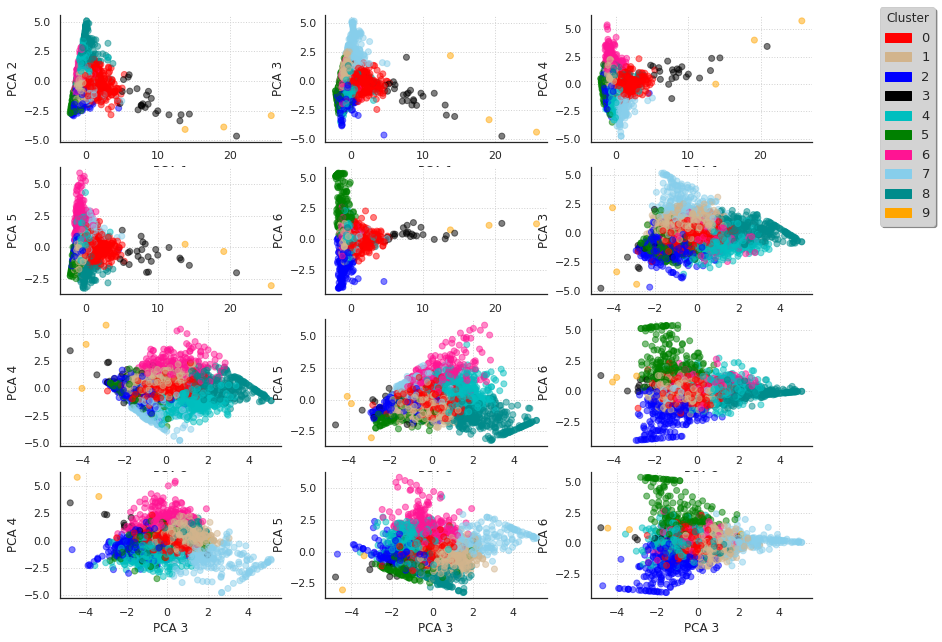

In [36]:
import matplotlib.patches as mpatches

sns.set_style("white")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

LABEL_COLOR_MAP = {0:'r', 1:'tan', 2:'b', 3:'k', 4:'c', 5:'g', 6:'deeppink', 7:'skyblue', 8:'darkcyan', 9:'orange'}
label_color = [LABEL_COLOR_MAP[l] for l in mat['cluster']]

fig = plt.figure(figsize = (12,10))
increment = 0
for ix in range(6):
    for iy in range(ix+1, 6):   
        increment += 1
        ax = fig.add_subplot(4,3,increment)
        ax.scatter(mat[ix], mat[iy], c= label_color, alpha=0.5) 
        plt.ylabel('PCA {}'.format(iy+1), fontsize = 12)
        plt.xlabel('PCA {}'.format(ix+1), fontsize = 12)
        ax.yaxis.grid(color='lightgray', linestyle=':')
        ax.xaxis.grid(color='lightgray', linestyle=':')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        if increment == 12: break
    if increment == 12: break

comp_handler = []
for i in range(n_clusters):
    comp_handler.append(mpatches.Patch(color = LABEL_COLOR_MAP[i], label = i))

plt.legend(handles=comp_handler, bbox_to_anchor=(1.1, 0.9), 
           title='Cluster', facecolor = 'lightgrey',
           shadow = True, frameon = True, framealpha = 1,
           fontsize = 13, bbox_transform = plt.gcf().transFigure)

plt.tight_layout()

## 5.2. Score de silhouette intra-cluster

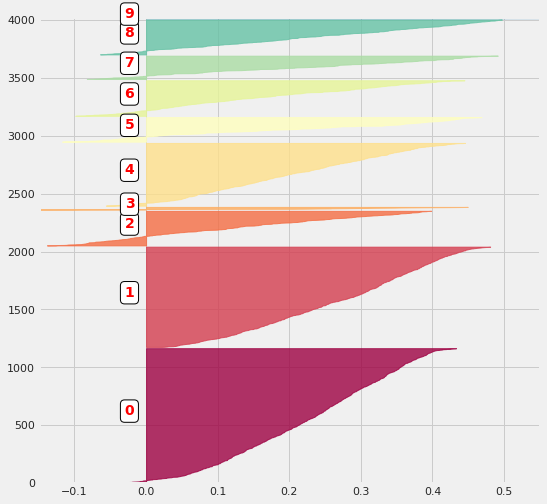

In [37]:
sample_silhouette_values = silhouette_samples(scaled, clusters_clients)
#__________________
# and do the graph
graph_component_silhouette(n_clusters, [-0.15, 0.55], len(scaled), sample_silhouette_values, clusters_clients)

## 5.3. Customers morphotype

In [38]:
selected_customers.loc[:, 'cluster'] = clusters_clients
selected_customers.head()

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,categ_5,LastPurchase,FirstPurchase,cluster
0,12346,1,77183.60,77183.60,77183.600000,77183.60,0.000000,0.000000,0.000000,100.000000,0.000000,0.000000,325,325,2
1,12747,11,301.70,675.38,381.455455,4196.01,49.613800,6.751652,0.972352,13.638671,26.362664,2.660861,2,369,0
2,12748,206,0.95,2026.70,156.880194,32317.32,23.200160,8.439097,16.132402,21.629207,15.753813,14.845321,0,373,3
3,12749,5,29.70,1866.43,808.176000,4040.88,35.405654,7.000950,4.281741,17.113104,12.146859,24.051692,3,213,0
4,12820,4,170.46,343.76,235.585000,942.34,0.000000,22.180954,15.552773,20.098903,22.949254,19.218117,3,326,0


In [39]:
merged_df = pd.DataFrame()
for i in range(n_clusters):
    test = pd.DataFrame(selected_customers[selected_customers['cluster'] == i].mean())
    test = test.T.set_index('cluster', drop = True)
    test['size'] = selected_customers[selected_customers['cluster'] == i].shape[0]
    merged_df = pd.concat([merged_df, test])

merged_df.drop('CustomerID', axis = 1, inplace = True)
print('number of customers:', merged_df['size'].sum())

merged_df = merged_df.sort_values('sum')
merged_df

number of customers: 3916


,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,categ_5,LastPurchase,FirstPurchase,size
cluster,,,,,,,,,,,,,,
5.0,2.122066,227.381221,351.783239,279.169213,590.546197,6.485789,3.962517,57.819424,15.798724,9.725535,6.208011,101.150235,178.474178,213
4.0,1.708487,284.991661,395.248856,337.823991,595.270443,22.295096,11.094622,11.010367,20.703789,17.793525,17.102602,263.459410,298.490775,542
6.0,2.500000,202.439253,349.196071,266.329687,671.728084,12.371536,44.515966,7.687229,14.582278,9.443283,11.399709,91.925325,188.905844,308
1.0,2.146651,290.791709,460.677194,368.462927,757.767483,18.655504,8.256526,12.376347,22.074942,18.464673,20.172008,40.720554,84.115473,866
8.0,2.645695,220.586954,472.569073,320.086244,887.976060,68.664266,4.298740,2.917856,7.006720,6.375997,10.736421,142.225166,225.791391,302
2.0,2.468227,502.520702,648.740167,571.348090,1031.065184,6.745817,4.645812,11.380999,59.099545,9.904598,8.223228,109.066890,184.528428,299
7.0,3.198020,232.261980,513.591089,348.350521,1272.058614,6.600322,3.506928,5.882941,10.137002,66.416686,7.456121,92.193069,211.638614,202
0.0,7.614520,162.315376,717.482411,381.370782,3002.045203,19.656758,10.021581,11.679286,22.082604,19.512197,17.047574,32.503889,317.370787,1157
3.0,61.291667,35.602917,4631.983333,1000.618110,42702.517917,22.671188,9.021250,10.069106,17.764906,25.985431,14.488119,4.625000,355.958333,24


## 군집별 특성
- 0: 매출이 양호한 고객
- 1: 신규 고객
- 2: categ_3
- 3: 매출이 우수한 고객
- 4: 이탈한 것으로 보이는 고객
- 5: categ_2
- 6: categ_1
- 7: categ_4
- 8: categ_0
- 9: 매출이 아주 우수한 고객, categ_4